# Projet 5 : Segmentez des clients d'un site e-commerce

L’objectif de ce projet est de segmenter les clients d’un site e-commerce afin d’identifier des groupes homogènes pour mieux cibler les actions marketing.  
La segmentation doit rester pertinente dans le temps : il s’agit donc d’évaluer la stabilité des groupes et de recommander une fréquence de mise à jour adaptée au contexte de l’entreprise.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import nbimporter
import fonctions as fc
from fonctions import df_agg_cust

# Pour garantir la reproductibilité des résultats
import numpy as np
import random

np.random.seed(42)
random.seed(42)

# Table des matières

1. [Chargement et préparation des données](#1)
2. [Découpage temporel du dataset](#2)
    * [2.1 Fonction de découpage du dataset](#3)
    * [2.2 Fonction de création du modèle initial](#4)
3. [Analyse de la stabilité des clusters dans le temps](#5)
    * [3.1 Fonction de comparaison des clusters](#6)
    * [3.2 Calcul et affichage des scores ARI pour chaque période](#7)
    * [3.3 Visualisation de l’évolution du score ARI](#8)
4. [Recommandation sur la fréquence de mise à jour du modèle](#9)
    * [4.1 Test avec une période d’entraînement plus large](#10)
    * [4.2 Conclusion sur la fréquence de mise à jour](#11)

# 1. Chargement et préparation des données

In [4]:
data = pd.read_csv('data_cleaned_all.csv')
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,00e7ee1b050b8499577073aeb2a297a1,06b8999e2fba1a1fbc88172c00ba8bc7,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,861eff4711a542e4b93843c6dd7febb0,14409.0,...,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,office_furniture
1,c1d2b34febe9cd269e378117d6681172,8912fc0c3bbf1e2fbf35819e21706718,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,9eae34bbd3a474ec5d07949ca7de67c0,68030.0,...,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,office_furniture
2,c1d2b34febe9cd269e378117d6681172,8912fc0c3bbf1e2fbf35819e21706718,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,9eae34bbd3a474ec5d07949ca7de67c0,68030.0,...,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,office_furniture
3,b1a5d5365d330d10485e0203d54ab9e8,f0ac8e5a239118859b1734e1087cbb1f,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12,3c799d181c34d51f6d44bbbc563024db,92480.0,...,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,office_furniture
4,2e604b3614664aa66867856dba7e61b7,6bc8d08963a135220ed6c6d098831f84,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22,23397e992b09769faf5e66f9e171a241,25931.0,...,1141.0,1.0,8683.0,54.0,64.0,31.0,8577.0,itaquaquecetuba,SP,office_furniture


# 2. Découpage temporel du dataset

In [5]:
col_date = ['order_purchase_timestamp',
            'order_approved_at', 'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date', 'shipping_limit_date']

data[col_date] = data[col_date].apply(pd.to_datetime,
                                      format='%Y-%m-%d %H:%M:%S.%f')

In [6]:
col_cat = ['order_status', 'customer_zip_code_prefix', 'customer_city',
           'customer_state', 'payment_type', 'seller_zip_code_prefix',
           'seller_city', 'seller_state', 'product_category_name_english']


data[col_cat] = data[col_cat].astype('category')

In [7]:
data.dtypes


order_id                                 object
customer_id                              object
order_status                           category
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
customer_zip_code_prefix               category
customer_city                          category
customer_state                         category
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
payment_sequential                      float64
payment_type                           category
payment_installments                    

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)

Déterminer la période couverte par le jeu de données en termes de dates de commandes, et afficher la durée totale en jours :

In [9]:
date_max = data['order_purchase_timestamp'].dt.date.max()
date_min = data['order_purchase_timestamp'].dt.date.min()
print('Le data set va de {} à {}, soit {} jours.'
      .format(date_min, date_max, (date_max-date_min).days))

Le data set va de 2016-10-03 à 2018-08-29, soit 695 jours.


## 2.1 Fonction de découpage temporel

Fonction df_periode :

1. Cette fonction prend une table avec des dates.
2. Elle regarde la première date, puis garde seulement les lignes qui sont entre cette première date et une date un peu plus loin (environ un an plus quelques semaines).
3. Elle donne ce nouveau tableau réduit.

In [10]:
def df_periode(df, delta):
    '''Prend un dataframe et un intervalle de temps,
    calcul une date maximale et retourne le dataframe dont
    les valeurs sont inférieures à cette date.
    Keyword arguments:
    df -- le dataframe
    delta -- intervalle de temps

    return : le dataframe réduit.
    '''

    # On récupère la date la plus ancienne dans la colonne order_purchase_timestamp du DataFrame
    date_min = df['order_purchase_timestamp'].dt.date.min()

    # On calcule un nombre de semaines : 52 semaines (1 an) plus deux fois la valeur de delta
    week = 52 + (delta * 2)

    # On ajoute ce nombre de semaines à la date minimale pour obtenir la date maximale de la période à conserver
    date_max = date_min + dt.timedelta(weeks=week)

    
    # On filtre le DataFrame pour ne garder que les lignes dont la date d’achat est comprise entre date_min et date_max
    df_delta = df[(df['order_purchase_timestamp'].dt.date >= date_min) &
                  (df['order_purchase_timestamp'].dt.date <= date_max)]

    # On retourne ce DataFrame filtré
    return df_delta

In [11]:
# Sélection des variables pour la segmentation
col_select = ['time_since_last_order', 'nb_total_order',
              'nb_total_item', 'total_price','mean_review_score']

## 2.2 Fonction de création du modèle initial 

Fonction model_init :

But :
Créer le modèle de départ (KMeans) sur une période initiale.

Ce qu’elle fait :

- Prend les données d’une période donnée (delta).
- Regroupe les données par client.
- Prépare les données (mise à l’échelle, encodage).
- Entraîne un modèle KMeans pour créer des groupes de clients.
- Retourne le transformateur (scaler) et le modèle KMeans entraîné.
  
Utilité :
C’est la fonction qui sert à créer la référence, le modèle de base sur lequel on va comparer les autres périodes.

In [12]:
def model_init(data, col, delta):
    '''Créer le dataframe initial et applique la modélisation
    sélectionnée dans le notebook de modélisation.
    Keyword arguments:
    data -- le dataframe
    col -- colonnes à selectionner dans le dataframe
    delta -- intervalle de temps

    return : le scaler et le model.
    '''

    # création du df
    df_init = df_periode(data, delta)
    df_0 = df_agg_cust(df_init)
    df_0 = df_0[col]

    # preprocessing
    col_quanti = df_0.select_dtypes(['int64', 'float64']).columns
    col_quali = df_0.select_dtypes(['category', 'object', 'bool']).columns

    minmax_scale = MinMaxScaler()
    ohe = OneHotEncoder()
    preprocessor = ColumnTransformer(transformers=[
        ('quanti', minmax_scale, col_quanti),
        ('quali', ohe, col_quali)])

    scale_0 = preprocessor.fit(df_0)
    df_0_scaled = scale_0.transform(df_0)

    # modélisation
    kmeans.fit(df_0_scaled)
    df_0['Cluster'] = kmeans.predict(df_0_scaled)

    return scale_0, kmeans

52 + (delta * 2) semaines → 52 + (0 * 2) = 52 semaines : 

In [13]:
scale_0, kmeans = model_init(data, col_select, 0)

fonctions.ipynb:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    df -- le dataframe\n",
fonctions.ipynb:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    return : dataframe agrégé et groupé en fonction de\n",
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# 3. Analyse de la stabilité des clusters dans le temps

## 3.1. Fonction de comparaison des clusters 

Fonction model_periode : 

But :
Comparer les groupes de clients trouvés sur différentes périodes à ceux du modèle initial.

Ce qu’elle fait :

- Pour chaque période entre p_min et p_max :
- Prend les données de cette période.
- Regroupe par client, prépare les données.
- Prédit à quel groupe chaque client appartiendrait selon le modèle initial.
- Crée de nouveaux groupes avec un nouveau KMeans.
- Compare les deux regroupements avec le score ARI (mesure de similarité).
- Retourne la liste des scores ARI pour chaque période.
  
Utilité :
Permet de voir si les groupes de clients restent stables ou changent au fil du temps.

In [14]:
def model_periode(data, col, k, p_min, p_max, scale, model_initial):
    '''Calcule le score ARI entre chaque période.
    Keyword arguments:
    data -- le dataframe
    col -- colonnes à selectionner dans le dataframe
    k -- nombre de cluster pour le Kmeans
    p_min -- nombre minimal de la période
    p_max -- nombre maximal de la période
    scale -- scaler du modèle initial
    model_initial -- modèle initial

    return : les scores ARI pour chaque période.
    '''

    ARI = []

    for p in range(p_min, p_max+1):

        # Création du dataframe à chaque nouvelle période
        df_p = df_periode(data, p)
        df_p = df_agg_cust(df_p)
        df_p = df_p[col]

        # Preprocessing
        col_quanti = df_p.select_dtypes(['int64', 'float64']).columns
        col_quali = df_p.select_dtypes(['category', 'object', 'bool']).columns

        minmax_scale = MinMaxScaler()
        ohe = OneHotEncoder()
        preprocessor = ColumnTransformer(transformers=[
            ('quanti', minmax_scale, col_quanti),
            ('quali', ohe, col_quali)])

        df_p_scaled = preprocessor.fit_transform(df_p)

        # Prédiction avec le kmeans initial
        df_p_scaled_init = scale.transform(df_p)
        df_p['Cluster_initial'] = model_initial.predict(df_p_scaled_init)

        # Modélisation
        kmeans_period = KMeans(n_clusters=k, random_state=42)

        kmeans_period.fit(df_p_scaled)
        df_p['Cluster'] = kmeans_period.predict(df_p_scaled)

        # Calcul de l'ARI
        score_p = adjusted_rand_score(df_p['Cluster'], df_p['Cluster_initial'])
        ARI.append([p, score_p])

    return ARI

- Comparer les groupes de clients (clusters) trouvés par KMeans sur différentes périodes allant de 0 à 24 (donc 25 périodes différentes).
- Utiliser 4 groupes (clusters) pour chaque période.
- Utiliser le modèle initial (scale_0 et kmeans) comme référence.
- Pour chaque période, calculer le score ARI qui mesure à quel point les groupes de cette période ressemblent à ceux du modèle initial.

## 3.2. Calcul et affichage des scores ARI pour chaque période

In [15]:
ARI = model_periode(data, col_select, 4, 0, 24, scale_0, kmeans)

fonctions.ipynb:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    df -- le dataframe\n",
fonctions.ipynb:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    return : dataframe agrégé et groupé en fonction de\n",
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
fonctions.ipynb:174: SettingWithCopyWarning: 
A value

In [16]:
print('Voici les scores ARI pour chaque période :')
ARI

Voici les scores ARI pour chaque période :


[[0, 1.0],
 [1, 0.936469106048478],
 [2, 0.8926624937141356],
 [3, 0.8490677540519647],
 [4, 0.8347883216938091],
 [5, 0.8108698977174327],
 [6, 0.7455229031312588],
 [7, 0.7091876202316705],
 [8, 0.6858223054978536],
 [9, 0.6677113959320685],
 [10, 0.6490150928689392],
 [11, 0.6315964933081666],
 [12, 0.6075625032131616],
 [13, 0.5689606037347916],
 [14, 0.5265915371015161],
 [15, 0.5139754915657546],
 [16, 0.49726138446305324],
 [17, 0.4598297692151688],
 [18, 0.4350948273533752],
 [19, 0.41504216448384457],
 [20, 0.39558728326642445],
 [21, 0.377730858428361],
 [22, 0.3591426906580039],
 [23, 0.3490310218971639],
 [24, 0.333636137916969]]

## 3.3 Visualisation de l’évolution du score ARI

In [17]:
def plot_ari(ARI):
    '''Affiche le score ARI en fonction de chaque période.
    Keyword arguments:
    ARI -- scores ARI de chaque période.
    '''

    df_ARI = pd.DataFrame(ARI, columns=['Période', 'Score'])

    plt.subplots(figsize=(15, 7))

    sns.lineplot(x=df_ARI['Période']*2,
                 y=df_ARI['Score']*100,
                 data=df_ARI, marker='o')

    for line in range(0, df_ARI.shape[0]):
        plt.text(x=df_ARI.Période[line]*2+0.3,
                 y=df_ARI.Score[line]*100,
                 s=(df_ARI.Score[line]*100).round(2))

    plt.axhline(y=80, color='gray', linestyle='--')

    plt.xticks(range(0, 50, 2))

    plt.xlabel('Semaines')
    plt.ylabel('Score ARI (en %)')

    plt.grid()
    plt.title("Évolution de l'ARI (Adjusted Rand Index) au cours du temps")
    plt.show()

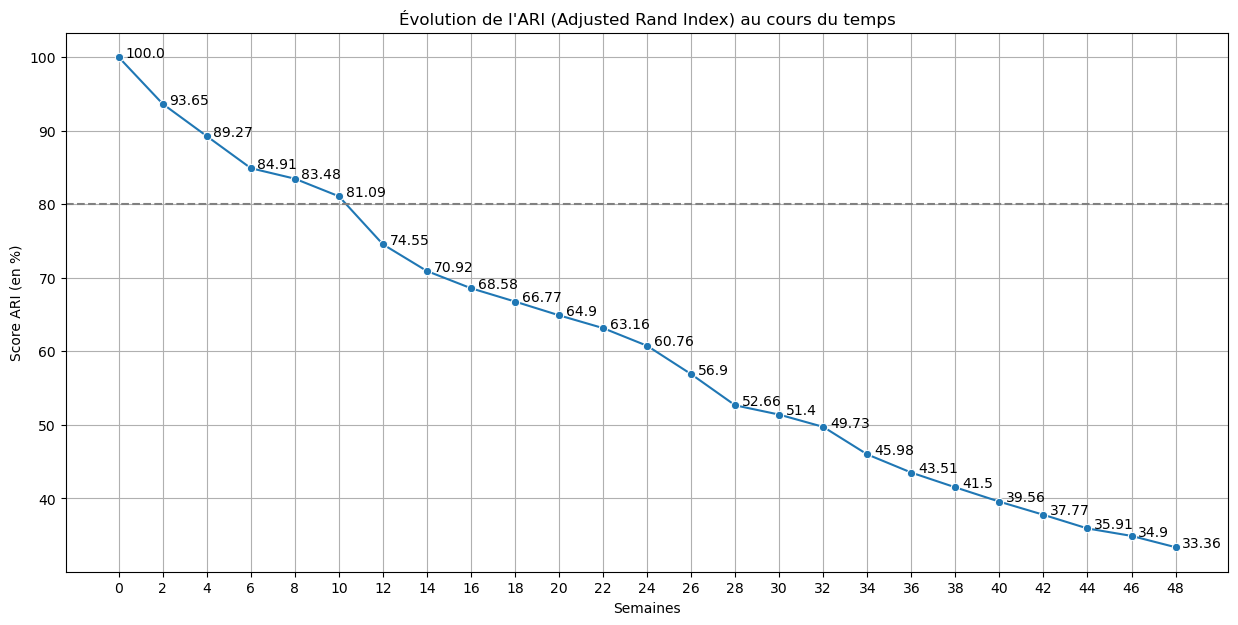

In [18]:
plot_ari(ARI)

Dans la fonction `plot_ari`, on utilise les **scores ARI** calculés pour chaque période par la fonction `model_periode`.

- Les données utilisées sont une liste de paires `[période, score_ARI]`, où chaque score ARI mesure la similarité entre les groupes de clients d’une période et ceux du modèle initial. 
- Ces scores sont transformés en DataFrame pour être affichés.
- L’axe des abscisses (x) représente les périodes (multipliées par 2 pour avoir le nombre de semaines).
- L’axe des ordonnées (y) montre le score ARI en pourcentage.

Donc : on affiche l’évolution de la similarité des groupes de clients au fil des périodes, en utilisant les scores ARI calculés précédemment.

# 4. Recommandation sur la fréquence de mise à jour du modèle

On constate qu'après 10 semaines (soit 2,5 mois) le score ARI diminue assez fortement et passe sous le seuil de 80%. Nous pouvons donc supposer que notre modèle de clustering doit être mis à jour après 2,5 mois.

Dans cette première approche, le modèle de segmentation (KMeans) est entraîné uniquement sur la période initiale (la première année de données).  

L’objectif est de mesurer la stabilité des groupes de clients dans le temps : pour chaque nouvelle période, on compare les clusters prédits par le modèle initial à ceux obtenus en recalculant un nouveau KMeans sur cette période.

**Intérêt :**  
Cela permet de savoir combien de temps la segmentation reste pertinente sans être réentraînée, et donc de déterminer la fréquence minimale de mise à jour nécessaire pour garder des groupes cohérents.

## 4.1. Test avec une période d’entraînement plus large

model_init entraîne un modèle KMeans sur les 8 premières semaines de données (période initiale plus large que précédemment).

Dans cette seconde approche, le modèle de segmentation est entraîné sur une période initiale plus longue (8 semaines supplémentaires). 

On répète le même processus : pour chaque période suivante, on compare la stabilité des clusters obtenus par le modèle initial à ceux recalculés sur la période.

**Intérêt :**  
Cette approche teste si entraîner le modèle sur une période plus large permet d’obtenir une segmentation plus stable dans le temps, et donc d’espacer les mises à jour (ce qui peut être intéressant pour optimiser le budget de maintenance).

Pertinence de cette double approche : 

But : Tester si la durée de la période d’entraînement influence la stabilité des clusters dans le temps.

- Si le modèle entraîné sur une période plus longue reste stable plus longtemps, cela signifie qu’il “généralise” mieux et qu’on peut espacer les mises à jour (ce qui est intéressant si le budget est limité).
- Si la stabilité chute au même rythme, cela montre que même en élargissant la période d’entraînement, il faut quand même mettre à jour la segmentation régulièrement.

In [19]:
scale_0, kmeans = model_init(data, col_select, 8)

fonctions.ipynb:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    df -- le dataframe\n",
fonctions.ipynb:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    return : dataframe agrégé et groupé en fonction de\n",
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


On entraîne le modèle de segmentation (KMeans) sur les 8 premières périodes (soit 16 semaines si chaque période = 2 semaines).

La fonction :
- Prend les données de cette période,
- Prépare les variables sélectionnées (col_select),
- Applique le préprocessing (mise à l’échelle, encodage),
- Entraîne le modèle KMeans,
- Retourne le scaler (scale_0) et le modèle KMeans entraîné (kmeans).

In [20]:
ARI = model_periode(data, col_select, 4, 8, 24, scale_0, kmeans)

fonctions.ipynb:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    df -- le dataframe\n",
fonctions.ipynb:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    return : dataframe agrégé et groupé en fonction de\n",
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
fonctions.ipynb:174: SettingWithCopyWarning: 
A value

On évalue la stabilité des clusters sur les périodes suivantes, de la période 8 à la période 24 (soit de 16 à 48 semaines).

Pour chaque période :
- On regroupe les clients,
- On prédit leur cluster avec le modèle initial,
- On recalcule un nouveau KMeans sur la période,
- On compare les deux segmentations avec le score ARI.
  
Résultat : On obtient une liste de scores ARI qui mesurent la similarité entre les clusters du modèle initial et ceux recalculés sur chaque période testée.

In [21]:
print('Voici les scores ARI pour chaque période :')
ARI

Voici les scores ARI pour chaque période :


[[8, 1.0],
 [9, 0.9589098652342021],
 [10, 0.9222814231778106],
 [11, 0.8874042199363431],
 [12, 0.838594230821045],
 [13, 0.8140108563914563],
 [14, 0.7791708572073075],
 [15, 0.765757571529914],
 [16, 0.7443410036438652],
 [17, 0.6735914494271795],
 [18, 0.6198436528037357],
 [19, 0.5962418246933157],
 [20, 0.5659825818159918],
 [21, 0.5317141556658715],
 [22, 0.5071975198278262],
 [23, 0.49443501899756226],
 [24, 0.4752891447647054]]

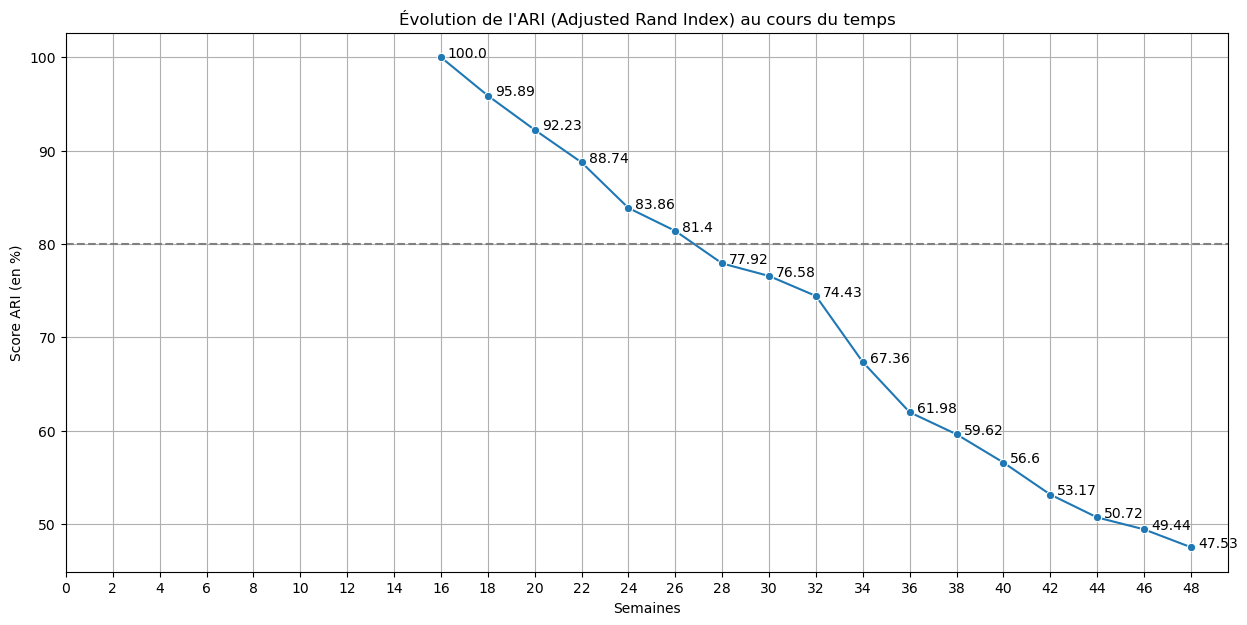

In [22]:
plot_ari(ARI)

On constate une nouvelle fois que notre modèle doit être mis à jour après 10 semaines (soit 2,5 mois), peu importe la période initialement utilisée pour entraîner le modèle.

On démarre l’évaluation à la période 8, cela fait : 8 × 2 = 16 semaines.

Le graphique ARI commence donc à 16 semaines, car c’est à partir de là que l'on compare la stabilité des clusters sur les périodes suivantes

## 4.2. Conclusion sur la fréquence de mise à jour

Conclusion et recommandations pour l’équipe marketing : 

Les deux tests ARI montrent que, quelle que soit la durée de la période d’entraînement du modèle initial (courte ou plus large), la stabilité des clusters chute fortement après environ 10 semaines.  
Cela signifie qu’élargir la période d’entraînement n’apporte pas de gain significatif en termes de stabilité dans le temps.

**Conclusion :**  
Pour garantir la pertinence de la segmentation client, il est recommandé de mettre à jour le modèle tous les 2 à 3 mois.  
Allonger la période d’entraînement ne permet pas d’espacer les mises à jour : la dynamique des comportements clients impose une actualisation régulière, même si cela a un coût.

**Recommandation :**  
- Si la précision de la segmentation est prioritaire, privilégier une mise à jour tous les 2 à 2,5 mois.
- Si le budget est contraint, une mise à jour trimestrielle reste acceptable, mais avec une légère perte de pertinence.

L’équipe marketing pourra ainsi planifier ses campagnes en s’appuyant sur des segments clients à jour, tout en maîtrisant le budget alloué à la maintenance du modèle de segmentation.